# $NH_3$ Test for different $\dot{m}_L$ values

In [8]:
# Step 1: Third-party module imports
import numpy as np # Scientific computing
import matplotlib.pyplot as plt # Visualisation
# CryoEvap module imports
from cryoevap.storage_tanks import Tank
from cryoevap.cryogens import Cryogen
import time

# Step 2: Initialise tank object
Q_roof = 0 		# Roof heat ingress / W
d_i = 0.201 		# Internal diameter / m
d_o = 0.204   		# External diameter / m
T_air = 298.15 		# Temperature of the environment K
U_L = 0.026 		# Liquid overall heat transfer coefficient W/m^2/K
U_V = 0.026 		# Vapour overall heat transfer coefficient W/m^2/K
Q_b = 0 		# Heat transfer rate at the bottom / W
V_tank = 6.75e-3 	# Tank volume / m^3
LF = 0.278  		# Initial liquid filling / -
P = 100000 		# Tank operating pressure / Pa
m_L_values = np.array([0, 1, 5, 10, 25]) * 1e-6  # Different mass flow rates to simulate


# Step 3: Initialise cryogen
ammonia = Cryogen(name = "ammonia") # Initialize cryogen object
ammonia.set_coolprops(P)

tanks_V_L = []  # List to store tank objects for different mass flow rates
tanks_BOG = []  # List to store boil-off gas data for different mass flow rates
tanks_Tv = []  # List to store vapour temperature data for different mass flow rates

for m_L in m_L_values:
    small_tank = Tank(d_i, d_o, V_tank, LF, m_L) # Initialize large-scale tank
    small_tank.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b, eta_w = 0.963)

    small_tank.cryogen = ammonia	# Set initialised cryogen as a tank property

    # Step 4: Simulation setup
    dz = 0.005 # grid spacing / m
    n_z = 1 + int(np.round(small_tank.l_V/dz, 0)) # Number of nodes
    small_tank.z_grid = np.linspace(0, 1, n_z) # Set dimensionless grid
    small_tank.U_roof = 0 # Roof overall heat transfer coefficient W/m^2/K
    evap_time = 3600*16 # Define evaporation time / s
    small_tank.time_interval = 60 # Time-step to record data
    small_tank.plot_interval = evap_time/6 # Interval to plot vapour temperature profiles
    initial_time = time.time() # Start timer
    small_tank.evaporate(evap_time) # Simulate the evaporation
    elapsed_time = time.time() - initial_time
    print(f"Simulation for m_L = {m_L*1e6:.1f}e-6 kg/s took {elapsed_time:.2f} seconds")

    # Save the data from the simulation
    tanks_V_L.append(small_tank.data['V_L'])
    tanks_BOG.append(small_tank.data['BOG'])
    tanks_Tv.append(small_tank.data['Tv_avg'])

Simulation for m_L = 0.0e-6 kg/s took 259.99 seconds
Simulation for m_L = 1.0e-6 kg/s took 264.35 seconds
Simulation for m_L = 5.0e-6 kg/s took 284.99 seconds
Simulation for m_L = 10.0e-6 kg/s took 314.71 seconds
Simulation for m_L = 25.0e-6 kg/s took 459.47 seconds


Gráfico de la evolución del volumen del líquido en los tanques en función del tiempo para distintos flujos másicos de entrada

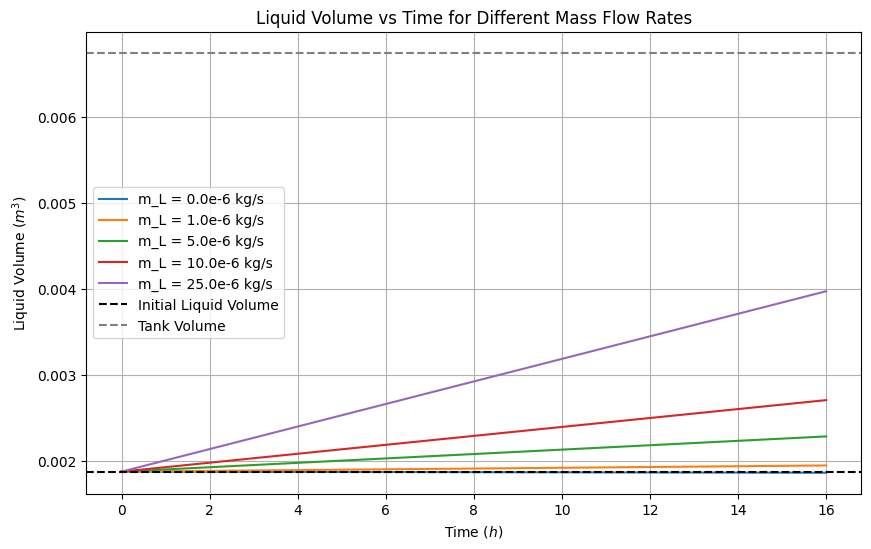

In [15]:
# Plot the V_L for different mass flow rates
plt.figure(figsize=(10, 6))
for i, m_L in enumerate(m_L_values):
    plt.plot(small_tank.data['Time']/3600, tanks_V_L[i], label=f'm_L = {m_L*1e6:.1f}e-6 kg/s')

# Plot an horizontal line for the initial liquid volume
initial_V_L = V_tank * LF
plt.axhline(y=initial_V_L, color='black', linestyle='--', label='Initial Liquid Volume')
plt.axhline(y=V_tank, color='gray', linestyle='--', label='Tank Volume')
plt.xlabel(r'Time ($h$)')
plt.ylabel(r'Liquid Volume ($m^3$)')
plt.title('Liquid Volume vs Time for Different Mass Flow Rates')
plt.legend()
plt.grid(True)
plt.show()

Gráfico de la tasa de *BOG* en función del tiempo para diferentes flujos másicos de entrada

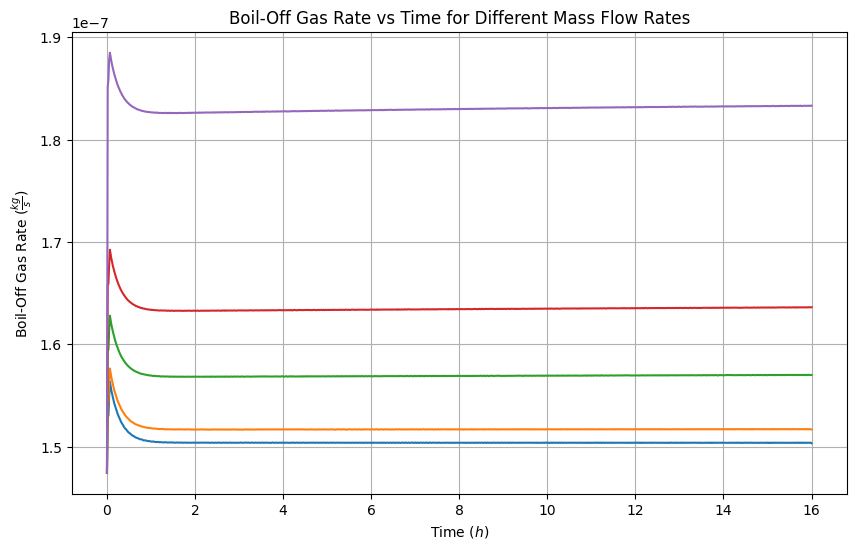

In [17]:
# Plot the BOG for different mass flow rates
plt.figure(figsize=(10, 6))
for i, m_L in enumerate(m_L_values):
    plt.plot(small_tank.data['Time']/3600, tanks_BOG[i], label=f'm_L = {m_L*1e6:.1f}e-6 kg/s')
plt.xlabel(r'Time ($h$)')
plt.ylabel(r'Boil-Off Gas Rate ($\frac{kg}{s}$)')
plt.title('Boil-Off Gas Rate vs Time for Different Mass Flow Rates')
plt.grid(True)
plt.show()

Gráfico de la temperatura media del gas en función del tiepmo para diferentes flujos másicos de entrada

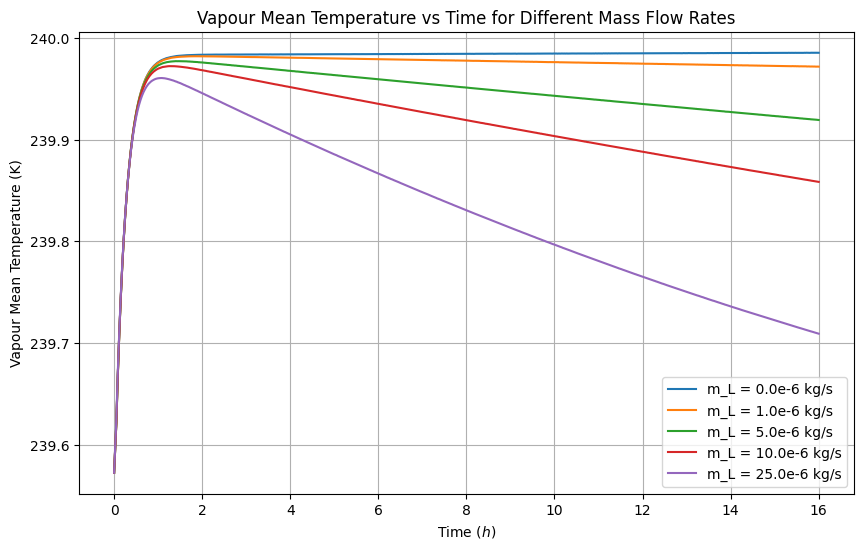

In [18]:
# Plot the Tv for different mass flow rates
plt.figure(figsize=(10, 6))
for i, m_L in enumerate(m_L_values):
    plt.plot(small_tank.data['Time']/3600, tanks_Tv[i], label=f'm_L = {m_L*1e6:.1f}e-6 kg/s')
plt.xlabel(r'Time ($h$)')
plt.ylabel(r'Vapour Mean Temperature (K)')
plt.title('Vapour Mean Temperature vs Time for Different Mass Flow Rates')
plt.legend()
plt.grid(True)
plt.show()